In [27]:
#CLEANING THE DATA 
#importing data set
import pandas as pd
og = pd.read_csv("emotional_monitoring_dataset_with_target.csv") 

#focusing on wearable compatible biometric data
columns_to_keep = ["HeartRate", "SkinConductance", "Temperature", "ActivityLevel", "AmbientNoiseLevel", "EngagementLevel"]
df = og[columns_to_keep].copy()

#normalizing the data 
from scipy.stats import zscore
cols_to_scale = ["HeartRate", "SkinConductance", "Temperature", "ActivityLevel", "AmbientNoiseLevel"]
df[cols_to_scale] = df[cols_to_scale].astype(float)
df.loc[:, cols_to_scale] = df[cols_to_scale].apply(zscore)


#LOGISTIC REGRESSION
#splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
X = df.drop(columns=["EngagementLevel"])
y = df["EngagementLevel"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#training logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

#COMPUTING ACCURACY METRICS 
#checking accuracy score
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

from sklearn.metrics import precision_score, recall_score, f1_score

# Macro average treats all classes equally
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1 Score (macro): {f1:.3f}")

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the output for multi-class ROC-AUC
y_test_bin = label_binarize(y_test, classes=sorted(y.unique()))
y_score = model.predict_proba(X_test)

# Compute AUC using One-vs-Rest approach
roc_auc = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
print(f"ROC-AUC Score (macro, OvR): {roc_auc:.3f}")

Model Coefficients: [[-0.03811536  1.93803414  0.11211369  0.55147719 -0.11697909]
 [ 0.37591734 -1.45121346 -0.47411266 -0.58318467  0.08084215]
 [-0.33780197 -0.48682069  0.36199897  0.03170747  0.03613694]]
Intercept: [-2.65463552  0.57800743  2.07662809]
Test Accuracy: 0.64
Precision (macro): 0.615
Recall (macro): 0.597
F1 Score (macro): 0.605
ROC-AUC Score (macro, OvR): 0.820


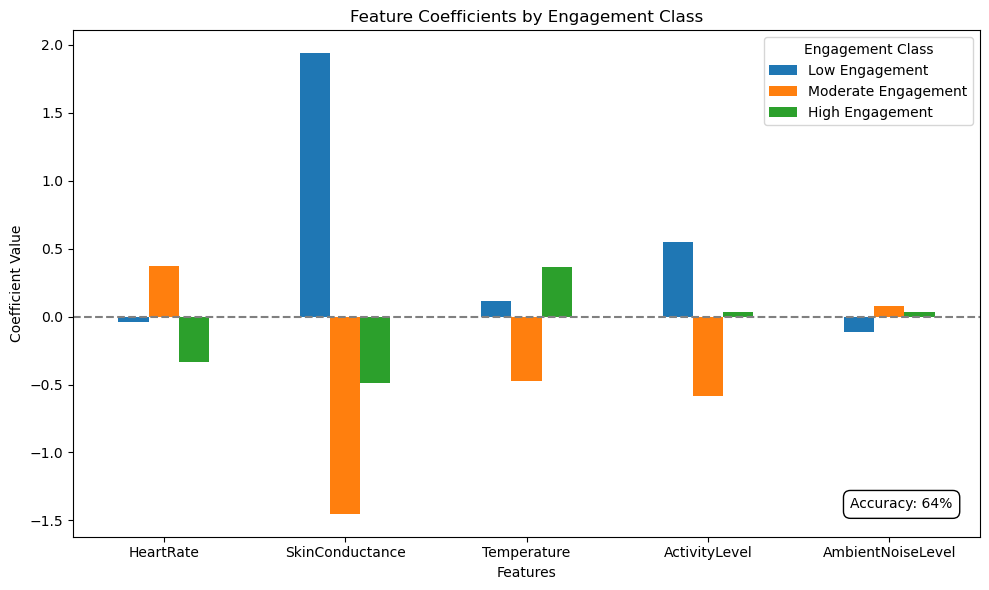

In [7]:
#PLOTTING FEATURE IMPORTANCE FOR LOGISTIC REGRESSION
import matplotlib.pyplot as plt
import pandas as pd

# Plotting a graph
features = ["HeartRate", "SkinConductance", "Temperature", "ActivityLevel", "AmbientNoiseLevel"]
coef_df = pd.DataFrame(model.coef_, columns=features, index=["Low Engagement", "Moderate Engagement", "High Engagement"])
ax = coef_df.T.plot(kind='bar', figsize=(10, 6))
plt.title("Feature Coefficients by Engagement Class")
plt.ylabel("Coefficient Value")
plt.xlabel("Features")
plt.xticks(rotation=0)
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title="Engagement Class")
plt.text(
    0.97, 0.05, "Accuracy: 64%", 
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
Tuned Model Accuracy: 0.64


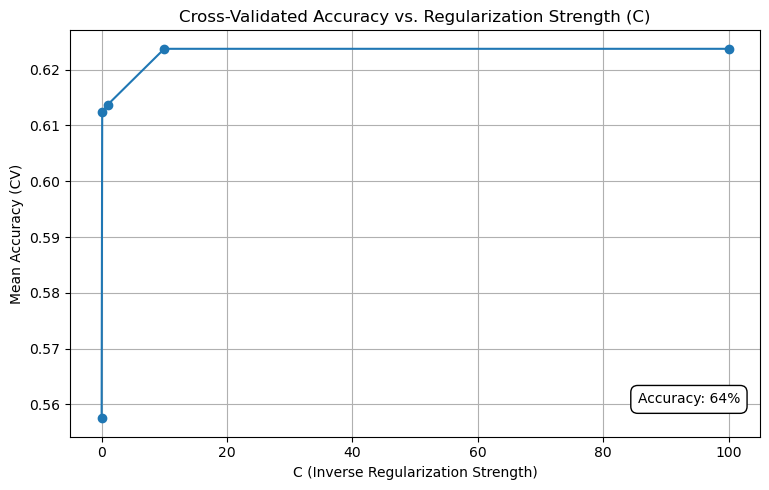

Precision (macro): 0.615
Recall (macro): 0.597
F1 Score (macro): 0.605
ROC-AUC Score (macro, OvR): 0.820


In [29]:
#HYPERTUNING PARAMETERS FOR LOGISTIC REGRESSION
#Using ridge regression to improve accuracy 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000],
}

# Initialize base model
logreg = LogisticRegression()

# GridSearch with 5-fold cross-validation
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

# Test accuracy
y_pred = best_model.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred))

# Convert results to DataFrame
results = pd.DataFrame(grid.cv_results_)

# Group by C to get mean accuracy across solvers
mean_scores = results.groupby('param_C')['mean_test_score'].mean()

# Plot accuracy vs C
plt.figure(figsize=(8, 5))
mean_scores.plot(marker='o')
plt.title("Cross-Validated Accuracy vs. Regularization Strength (C)")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("Mean Accuracy (CV)")
plt.grid(True)
plt.text(
    0.73, 0.05, "Accuracy: 64%", 
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)
plt.tight_layout()
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Macro average: evaluates across all classes equally
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1 Score (macro): {f1:.3f}")

# ROC-AUC Score using predicted probabilities
y_test_bin = label_binarize(y_test, classes=sorted(y.unique()))
y_score = best_model.predict_proba(X_test)

roc_auc = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
print(f"ROC-AUC Score (macro, OvR): {roc_auc:.3f}")

In [31]:
#LINEAR SVM MODEL 
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Define hyperparameter grid for linear SVM
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear']
}

# Initialize model with probability estimates enabled
svm_linear = SVC(probability=True)

# Run grid search with 5-fold cross-validation
grid = GridSearchCV(svm_linear, param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

# Retrieve best model and predict
print("Best Parameters:", grid.best_params_)
best_svm_linear = grid.best_estimator_
y_pred = best_svm_linear.predict(X_test)

# Accuracy
print("Linear SVM Test Accuracy:", accuracy_score(y_test, y_pred))

# Macro-averaged precision, recall, F1
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1 Score (macro): {f1:.3f}")

# ROC-AUC Score
y_test_bin = label_binarize(y_test, classes=sorted(y.unique()))
y_score = best_svm_linear.predict_proba(X_test)

roc_auc = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
print(f"ROC-AUC Score (macro, OvR): {roc_auc:.3f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'C': 10, 'kernel': 'linear'}
Linear SVM Test Accuracy: 0.68
Precision (macro): 0.672
Recall (macro): 0.621
F1 Score (macro): 0.634
ROC-AUC Score (macro, OvR): 0.839


In [37]:
#RBF KERNEL SVM
from sklearn.svm import SVC

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],        # regularization strength
    'gamma': ['scale', 0.01, 0.1, 1],  # kernel coefficient
    'kernel': ['rbf']              # Radial Basis Function kernel
}

# Initialize SVM model
svm = SVC(probability=True)

# Set up grid search with 5-fold cross-validation
grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

# Best model and test set accuracy
print("Best Parameters:", grid.best_params_)
best_svm = grid.best_estimator_

y_pred = best_svm.predict(X_test)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))

# Precision, Recall, F1 (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1 Score (macro): {f1:.3f}")

# ROC-AUC
y_test_bin = label_binarize(y_test, classes=sorted(y.unique()))
y_score = best_svm.predict_proba(X_test)

roc_auc = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
print(f"ROC-AUC Score (macro, OvR): {roc_auc:.3f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Test Accuracy: 0.885
Precision (macro): 0.831
Recall (macro): 0.818
F1 Score (macro): 0.824
ROC-AUC Score (macro, OvR): 0.973


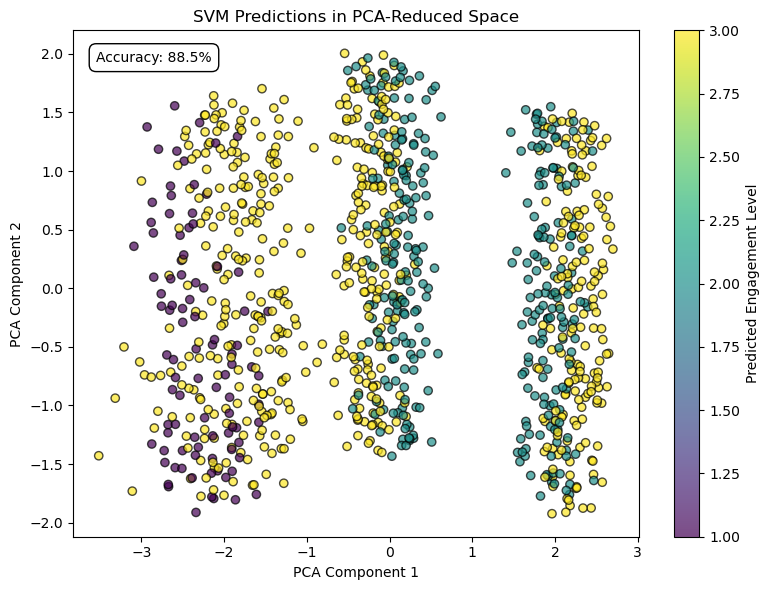

In [41]:
#PCA TO VISUALIZE THE DATA 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce the full feature space to 2D
X_all = df[cols_to_scale]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# Predict engagement levels using the best SVM
y_all = df["EngagementLevel"].values
y_pred_all = best_svm.predict(X_all)

# Plot the PCA-reduced data colored by predicted engagement level
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_all, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title("SVM Predictions in PCA-Reduced Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Predicted Engagement Level")
plt.text(
    0.02, 0.95, "Accuracy: 88.5%", 
    horizontalalignment='left',
    verticalalignment='top',
    transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)
plt.tight_layout()
plt.show()

Best RF Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.885
Precision (macro): 0.816
Recall (macro): 0.793
F1 Score (macro): 0.802
ROC-AUC Score (macro, OvR): 0.975


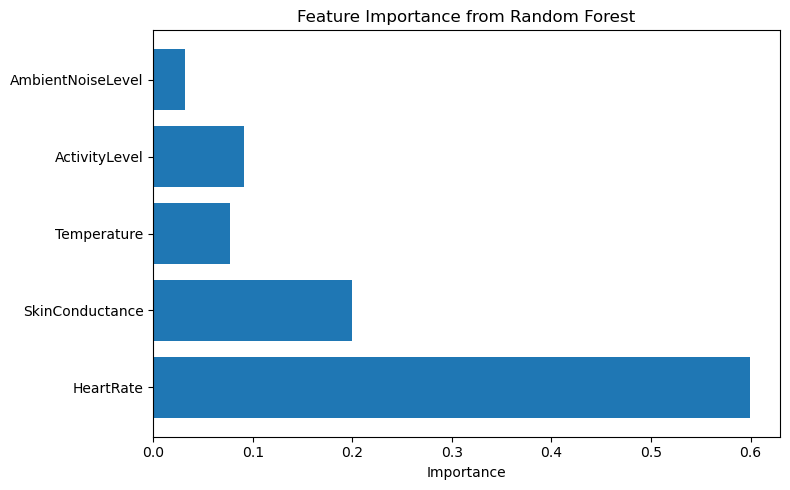

In [75]:
# RANDOM FOREST CLASSIFIER WITH HYPERPARAMETER TUNING
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pandas as pd

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Run GridSearchCV to find best parameters
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# Predict using best RF model
y_pred_rf = best_rf.predict(X_test)

# Evaluation Metrics
print("Best RF Params:", grid_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

precision = precision_score(y_test, y_pred_rf, average='macro')
recall = recall_score(y_test, y_pred_rf, average='macro')
f1 = f1_score(y_test, y_pred_rf, average='macro')

print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1 Score (macro): {f1:.3f}")

# ROC-AUC Score
y_test_bin = label_binarize(y_test, classes=sorted(y.unique()))
y_score_rf = best_rf.predict_proba(X_test)

roc_auc = roc_auc_score(y_test_bin, y_score_rf, average='macro', multi_class='ovr')
print(f"ROC-AUC Score (macro, OvR): {roc_auc:.3f}")

# Feature Importance Plot
plt.figure(figsize=(8, 5))
plt.barh(cols_to_scale, best_rf.feature_importances_)
plt.xlabel("Importance")
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()


XGBoost Accuracy: 0.9
Precision (macro): 0.843
Recall (macro): 0.822
F1 Score (macro): 0.831
ROC-AUC Score (macro, OvR): 0.976


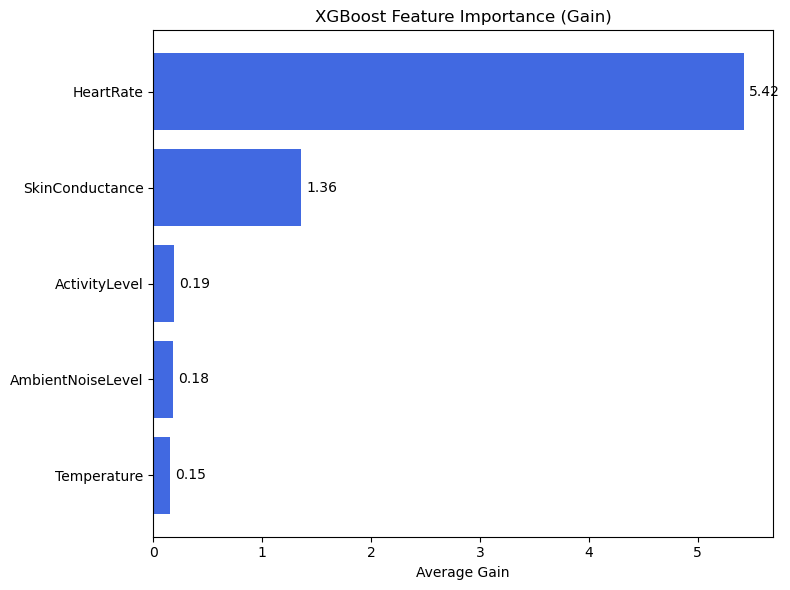

In [45]:
#XGBOOST MODEL 
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pandas as pd

# Shift labels
y_train_adj = y_train - 1
y_test_adj = y_test - 1

# Train XGBoost classifier
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_adj)


# Predict and shift predictions back up
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_final = y_pred_xgb + 1

# Accuracy
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb_final))

# Precision, Recall, F1 (macro)
precision = precision_score(y_test, y_pred_xgb_final, average='macro')
recall = recall_score(y_test, y_pred_xgb_final, average='macro')
f1 = f1_score(y_test, y_pred_xgb_final, average='macro')

print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1 Score (macro): {f1:.3f}")

# ROC-AUC
y_test_bin = label_binarize(y_test, classes=sorted(y.unique()))
y_score_xgb = xgb_model.predict_proba(X_test)

roc_auc = roc_auc_score(y_test_bin, y_score_xgb, average='macro', multi_class='ovr')
print(f"ROC-AUC Score (macro, OvR): {roc_auc:.3f}")

# Plotting Feature Importance
features = ["HeartRate", "SkinConductance", "ActivityLevel", "AmbientNoiseLevel", "Temperature"]
gains = [5.42, 1.36, 0.19, 0.18, 0.15]

importance_df = pd.DataFrame({
    "Feature": features,
    "Gain": gains
}).sort_values(by="Gain", ascending=True)

# Plot
plt.figure(figsize=(8, 6))
ax = plt.gca()
bars = ax.barh(importance_df["Feature"], importance_df["Gain"], color='royalblue')
ax.set_xlabel("Average Gain")
ax.set_title("XGBoost Feature Importance (Gain)")

# Annotate bars with gain values
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.05, bar.get_y() + bar.get_height()/2,
            f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()

In [65]:
#HYPERTUNING XGBOOST MODEL 
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score)
from sklearn.preprocessing import label_binarize

# Adjust labels
y_train_adj = y_train - 1
y_test_adj = y_test - 1

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(eval_metric='mlogloss', random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy'
)

grid_xgb.fit(X_train, y_train_adj)

# Use the best model
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_pred_xgb_final = y_pred_xgb + 1 

# Accuracy
print("Best XGBoost Params:", grid_xgb.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_final))

# Precision, Recall, F1
precision = precision_score(y_test, y_pred_xgb_final, average='macro')
recall = recall_score(y_test, y_pred_xgb_final, average='macro')
f1 = f1_score(y_test, y_pred_xgb_final, average='macro')

print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1 Score (macro): {f1:.3f}")

# ROC-AUC
y_test_bin = label_binarize(y_test, classes=sorted(y.unique()))
y_score_xgb = best_xgb.predict_proba(X_test)

roc_auc = roc_auc_score(y_test_bin, y_score_xgb, average='macro', multi_class='ovr')
print(f"ROC-AUC Score (macro, OvR): {roc_auc:.3f}")

Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Accuracy: 0.88
Precision (macro): 0.807
Recall (macro): 0.780
F1 Score (macro): 0.790
ROC-AUC Score (macro, OvR): 0.975


=== Bootstrapped Accuracy Summary ===
                     Mean Accuracy  2.5% CI  97.5% CI
Logistic Regression         0.6397    0.575    0.7000
Random Forest               0.8847    0.840    0.9251
XGBoost                     0.9000    0.855    0.9400
SVM                         0.8851    0.840    0.9250

=== Pairwise p-values (two-sided) ===
Logistic Regression vs Random Forest: p = 0.4670
Logistic Regression vs XGBoost: p = 0.4830
Logistic Regression vs SVM: p = 0.4830
Random Forest vs XGBoost: p = 0.4020
Random Forest vs SVM: p = 0.8990
XGBoost vs SVM: p = 0.6440


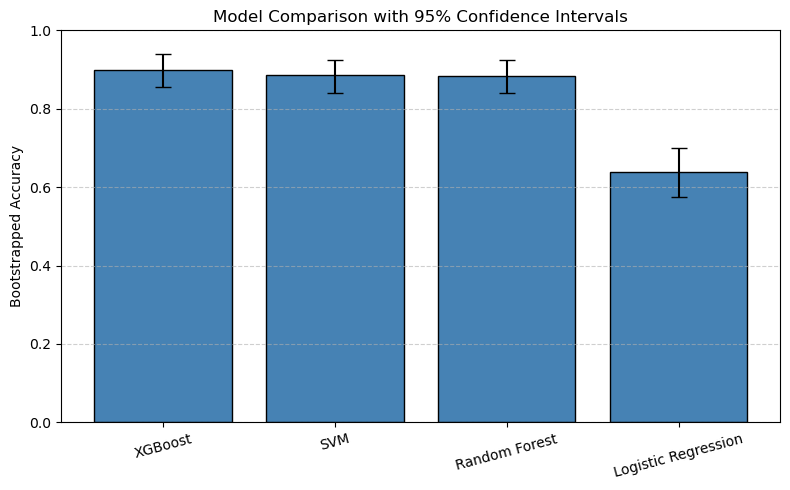

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.utils import resample


# Adjust XGBoost predictions
xgb_preds = xgb_model.predict(X_test)
if xgb_preds.min() == 0:
    xgb_preds = xgb_preds + 1  # shift back if trained with y-1


# Step 1: Define predictions
model_preds = {
    'Logistic Regression': best_model.predict(X_test),
    'Random Forest': best_rf.predict(X_test),
    'XGBoost': xgb_preds,
    'SVM': best_svm.predict(X_test)
}


# Step 2: Bootstrapping
n_bootstraps = 1000
rng = np.random.RandomState(42)
boot_results = {model: [] for model in model_preds}

for _ in range(n_bootstraps):
    indices = rng.choice(len(X_test), size=len(X_test), replace=True)
    y_true_boot = y_test.iloc[indices]

    for model, preds in model_preds.items():
        acc = accuracy_score(y_true_boot, np.array(preds)[indices])
        boot_results[model].append(acc)

boot_df = pd.DataFrame(boot_results)


# Step 3: Accuracy summary
summary = pd.DataFrame(index=boot_df.columns)
summary["Mean Accuracy"] = boot_df.mean()
summary["2.5% CI"] = boot_df.quantile(0.025)
summary["97.5% CI"] = boot_df.quantile(0.975)


# Step 4: Pairwise p-values
p_values = {}
models = list(model_preds.keys())

for i in range(len(models)):
    for j in range(i + 1, len(models)):
        diff = np.array(boot_df[models[i]]) - np.array(boot_df[models[j]])
        p_val = np.mean(np.abs(diff) >= np.abs(np.mean(diff)))
        p_values[f"{models[i]} vs {models[j]}"] = p_val


# Step 5: Print results
print("=== Bootstrapped Accuracy Summary ===")
print(summary.round(4))

print("\n=== Pairwise p-values (two-sided) ===")
for pair, p in p_values.items():
    print(f"{pair}: p = {p:.4f}")


# Step 6: Visualization
summary_sorted = summary.sort_values("Mean Accuracy", ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(
    summary_sorted.index,
    summary_sorted["Mean Accuracy"],
    yerr=[
        summary_sorted["Mean Accuracy"] - summary_sorted["2.5% CI"],
        summary_sorted["97.5% CI"] - summary_sorted["Mean Accuracy"]
    ],
    capsize=6,
    color="steelblue",
    edgecolor="black"
)

plt.ylabel("Bootstrapped Accuracy")
plt.title("Model Comparison with 95% Confidence Intervals")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
